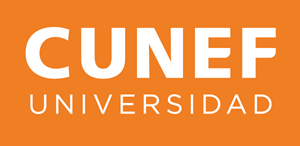
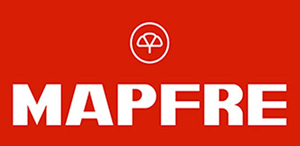

# Master en Data Science - Trabajo Final de Máster

# **5. Implementación de modelos predictivo y causal**
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
### <u>DataSet</u>: IBM - Telco Customer Churn

En este notebook se aplicarán dos modelos predictivos (Logistic Regression y LightGBM) al dataset, entrenando con train y midiendo los resultados con el set de test. Además, también se aplicará el modelo causal elegido, obteniendo ATE y CATE como resultados, para finalmente unificar ambos outputs en recomendaciones de negocio para el caso de uso específico.

## Librerías y funciones

Sección en la que se importan las librerías públicas y también se importan funciones personalizadas desde un script propio.

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import importlib
import warnings
import joblib

# Modelos
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
import scikitplot as skplt
from sklearn.metrics import balanced_accuracy_score, fbeta_score, make_scorer,\
                            accuracy_score, precision_recall_curve, roc_curve,\
                            auc, recall_score, precision_score, confusion_matrix,\
                            f1_score

# Modelado causal

## PyWhy
from econml.inference import BootstrapInference
from econml.metalearners import XLearner
from econml.dr import LinearDRLearner
from econml.dml import DML

# Configs
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

SEED=10

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [26]:
sys.path.append('../src/')
import functions_rfc_IBM as fr
importlib.reload(fr)
sys.path.remove('../src/')

## Importando los datasets de train y test

Se procede a importar los datasets de train y test para luego dividirlos en X e y

In [3]:
df_train_raw = pd.read_parquet('../data/ibm_telco_churn/df_telco_train.parquet')
df_test_raw = pd.read_parquet('../data/ibm_telco_churn/df_telco_test.parquet')
display(df_train_raw.head(), df_train_raw.shape)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
2125,0021-IKXGC,1,United States,California,San Marcos,92078,"33.119028, -117.166036",33.119028,-117.166036,Female,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,72.10,72.10,No,50,4432,None,0
6768,1395-OFUWC,1,United States,California,Los Angeles,90067,"34.057496, -118.413959",34.057496,-118.413959,Male,No,Yes,Yes,43,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.30,1224.05,No,70,4741,None,0
6796,8080-POTJR,1,United States,California,Rancho Palos Verdes,90275,"33.753146, -118.367459",33.753146,-118.367459,Female,No,No,No,30,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),79.30,2427.10,No,78,2655,None,0
476,3132-TVFDZ,1,United States,California,Glendale,91202,"34.167926, -118.267539",34.167926,-118.267539,Male,Yes,Yes,No,57,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.85,2572.95,Yes,82,5172,Attitude of support person,1
6706,3898-BSJYF,1,United States,California,Herlong,96113,"40.198234, -120.18089",40.198234,-120.180890,Female,No,No,Yes,10,Yes,Yes,DSL,Yes,No,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.55,693.30,No,29,4434,None,0


In [4]:
X_train = df_train_raw.drop(columns='Churn Value', axis=1)
y_train = df_train_raw['Churn Value']

X_test = df_test_raw.drop(columns='Churn Value', axis=1)
y_test = df_test_raw['Churn Value']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

## Preprocesamiento

Se lleva a cabo el preprocesamiento de los datasets mediante el uso de las funciones personalizadas al igual que en notebooks anteriores.

In [5]:
X_train_s = fr.feature_selection(X_train)
X_test_s = fr.feature_selection(X_test)

bools, cats, nums = fr.tipos_vars(X_train_s, show=False)

preprocessor = fr.Preprocessing(X_train_s,
                                cat_transf='mix',
                                scale=True,
                                cat_vars=cats,
                                num_vars=nums,
                                bool_vars=bools,
                                vars_ord=['Contract'],
                                nulls_strategy='median',
                                show_info=True,
                            )

preprocessor.fit(X_train_s, y_train)

X_train_t = preprocessor.transform(X_train_s)
X_test_t = preprocessor.transform(X_test_s)

display(X_train_t.head(), X_train_t.shape, X_test_t.shape)

Prprocessing pipeline defined with the following parameters:
        Mean encoding: ['Payment Method']
        Numerical transformation (scaling=True input strategy=median): ['Tenure Months' 'Monthly Charges' 'CLTV']
        Booleans encoding (ordinal 0-1): ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Paperless Billing']
        Ordinal encoding: ['Contract']
        One-Hot encoding: []


,Tenure Months,Monthly Charges,CLTV,Contract,Payment Method,Senior Citizen,Partner,Dependents,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Paperless Billing
2125,-1.299099,-0.217742,0.018351,0.0,0.471083,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
6768,0.411249,-2.175807,0.280323,0.0,0.190022,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6796,-0.118144,0.111652,-1.488203,1.0,0.190022,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
476,0.981365,-1.464407,0.645728,0.0,0.471083,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6706,-0.932596,-0.151406,0.020046,1.0,0.190022,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [6]:
df_train = pd.concat([X_train_t, y_train], axis=1)
df_test = pd.concat([X_test_t, y_test], axis=1)

## Modelado Predictivo: LightGBM y Logistic Regression

A continuación se ejecuntan los modelos predictivos mejor posicionados del benchmarking, uno paramétrico (Logistic Regression) y otro no paramétrico (LightGBM, modelo boosting).

In [7]:
cv = joblib.load('../models/CV_rs_lgbm_IBM.joblib')

In [8]:
cv.best_params_

{'num_leaves': 11,
 'n_estimators ': 200,
 'min_data_in_leaf': 400,
 'max_depth': 3,
 'learning_rate': 0.05,
 'lambda_l2': 0.5,
 'lambda_l1': 0}

In [9]:
lgbm = LGBMClassifier(verbose=-1
                      ,max_depth=3
                      ,min_data_in_leaf=400
                      ,n_estimators=200
                      ,num_leaves=11
                      ,learning_rate=0.05
                      ,random_state=SEED
                      ,lambda_l2=0.5
                     )

lgbm.fit(X_train_t, y_train)

y_pred_lgbm = lgbm.predict(X_test_t)

fr.metrics_summ(y_test, y_pred_lgbm)


Accuracy: 0.77899
Balanced Accuracy: 0.73455
F2 score: 0.62247
F1 score: 0.63798
Precision: 0.66563
Recall: 0.61254

Confusion Matrix:
[[645 108]
 [136 215]]


,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,Model,0.778986,0.734555,0.622467,0.637982,0.665635,0.612536


In [10]:
lr = LogisticRegression(random_state=SEED)

lr.fit(X_train_t, y_train)

y_pred_lr = lr.predict(X_test_t)

fr.metrics_summ(y_test, y_pred_lr)


Accuracy: 0.78080
Balanced Accuracy: 0.73512
F2 score: 0.62101
F1 score: 0.63881
Precision: 0.67085
Recall: 0.60969

Confusion Matrix:
[[648 105]
 [137 214]]


,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,Model,0.780797,0.735122,0.62101,0.638806,0.670846,0.609687


Vemos que los resultados de ambos modelos son prácticamente idénticos, uno con un mínimo más de accuracy y el otro con un mínimo más de recall, pero la diferencia es prácticamente imperceptible.

Ahora se toman como resultado las predicciones y se comienza el análisis gráfico de los resultados:

In [11]:
y_pred_proba_lgbm = lgbm.predict_proba(X_test_t)
probas_lgbm = pd.concat([pd.Series(y_pred_proba_lgbm[:,1]),pd.Series(y_pred_lgbm)],axis=1).rename(columns={0:'Probability', 1:'Default'})
probas_lgbm[probas_lgbm.Default == 1].Probability.describe()

count    323.000000
mean       0.666330
std        0.098385
min        0.500579
25%        0.581473
50%        0.660522
75%        0.731450
max        0.892173
Name: Probability, dtype: float64

In [12]:
probas_lgbm.mean()

Probability    0.318159
Default        0.292572
dtype: float64

In [13]:
y_pred_proba_lr = lr.predict_proba(X_test_t)
probas_lr = pd.concat([pd.Series(y_pred_proba_lr[:,1]),pd.Series(y_pred_lr)],axis=1).rename(columns={0:'Probability', 1:'Default'})
probas_lr[probas_lr.Default == 1].Probability.describe()

count    319.000000
mean       0.660932
std        0.087186
min        0.501344
25%        0.593807
50%        0.658975
75%        0.728392
max        0.861592
Name: Probability, dtype: float64

In [14]:
probas_lr.mean()

Probability    0.316265
Default        0.288949
dtype: float64

Una vez guardadas las probabilidades, se puede notar que tienen medias muy similares.

A continuación se realiza una exposición gráfica de las distribuciones de esas probabilidades, segmentadas por el valor verdadero de la variable target. Este gráfico resulta muy útil en problemas de clasificación, ya que nos permite visualizar que tan bien discrimina nuestro modelo predictivo entre los valores del target, es decir, en este caso en concreto por ejemplo, que tan bien está asignando esa propención de fuga a quienes realmente se fugan y a quienes no.

In [15]:
df_aux_lgbm = pd.concat([pd.Series(probas_lgbm.Probability)
                        ,y_test.reset_index(drop=False)
                        ], axis=1).rename(columns={'Probability':'y_pred_proba','Churn Value':'y_true'})

df_aux_lr = pd.concat([pd.Series(probas_lr.Probability)
                      ,y_test.reset_index(drop=False)
                      ], axis=1).rename(columns={'Probability':'y_pred_proba','Churn Value':'y_true'})

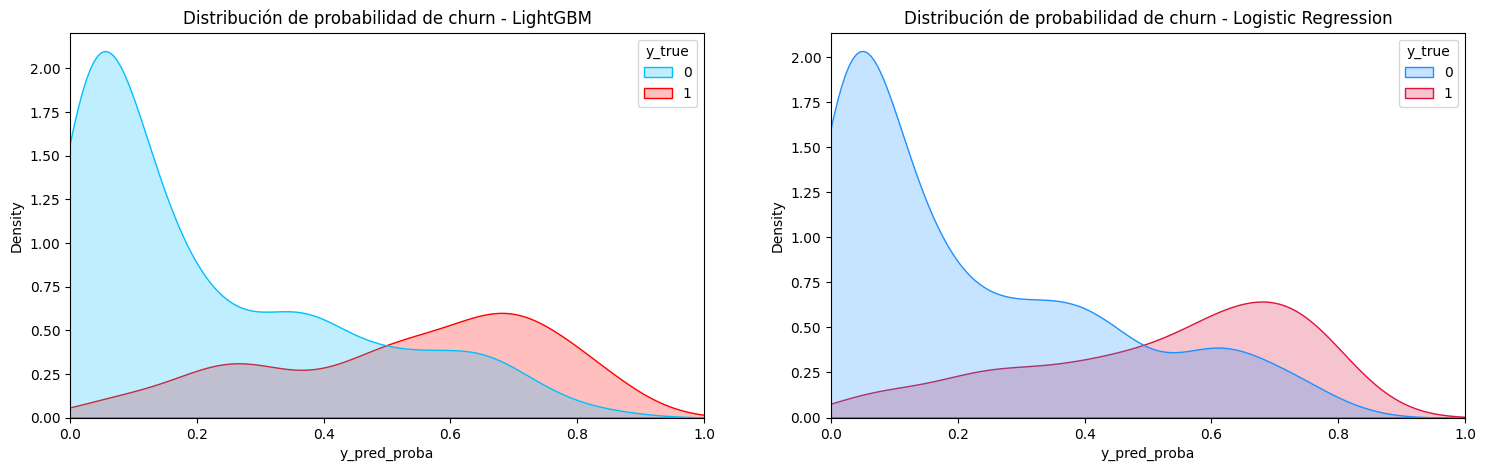

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

sns.kdeplot(data=df_aux_lgbm, x='y_pred_proba', hue='y_true', ax=ax1, fill=True, palette=['deepskyblue','red'])
sns.kdeplot(data=df_aux_lr, x='y_pred_proba', hue='y_true', ax=ax2, fill=True, palette=['dodgerblue','crimson'])

ax1.set_title('Distribución de probabilidad de churn - LightGBM')
ax1.set_xlim(0,1)

ax2.set_title('Distribución de probabilidad de churn - Logistic Regression')
ax2.set_xlim(0,1)

plt.show()

Nuevamente se puede observar una gran similitud entre ambas distribuciones. Lo positivo es que se nota una clara diferencia entre la distribucion de los clientes fugados y los que no, ya que mientras más difieran las distribuciones en cuanto a su ubicación, sesgo y colas, mejor estará discriminando el modelo, siendo la perfección un modelo con las distribuciones una en cada extremo.

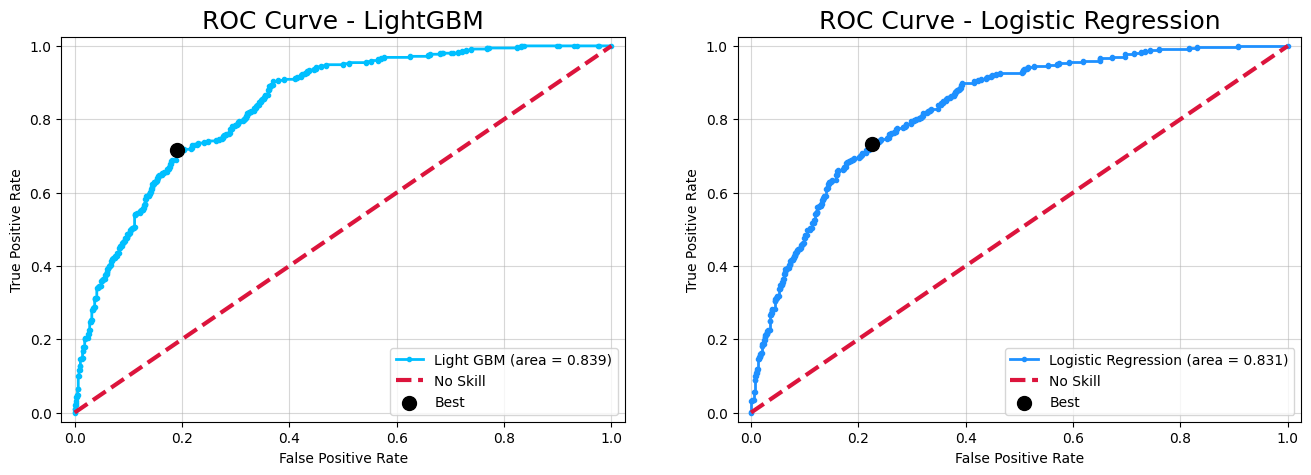

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

roc_metrics_lgbm = fr.roc_curve_plot(y_test
                                    ,probas_lgbm.Probability
                                    ,model_name='Light GBM'
                                    ,ax=ax1
                                    ,curve_color='deepskyblue'
                                    ,title='ROC Curve - LightGBM')

roc_metrics_lr = fr.roc_curve_plot(y_test
                                  ,probas_lr.Probability
                                  ,model_name='Logistic Regression'
                                  ,ax=ax2
                                  ,title='ROC Curve - Logistic Regression')
plt.show()

In [20]:
roc_metrics = pd.concat([roc_metrics_lgbm, roc_metrics_lr], axis=0)
roc_metrics

,Model,Best_threshold,G-Mean,Gini,ROC_AUC
0,Light GBM,0.419935,0.760492,0.677435,0.838717
0,Logistic Regression,0.384932,0.752922,0.661472,0.830736


Se observa que el área bajo la curva de ambos modelos es múy similar, mostrándo una minúscula superioridad de LightGBM, además de un threshold levemente superior.

El punto negro indica el mejor threshold, en donde en principio se lograría la mayor cantidad de verdaderos positivos en conjunto con la menor cantidad de falsos positivos, aunque no tiene porque ser este el objetivo de negocio que tenemos. Es decir, clasificar a muchísima gente como propenso a la fuga podría generar que incurramos en costos muy altos de aplicación del tratamiento, por ejemplo, aunque luego estas decisiones dependerán de cuestiones detalladas de negocio y eficiencia económica.

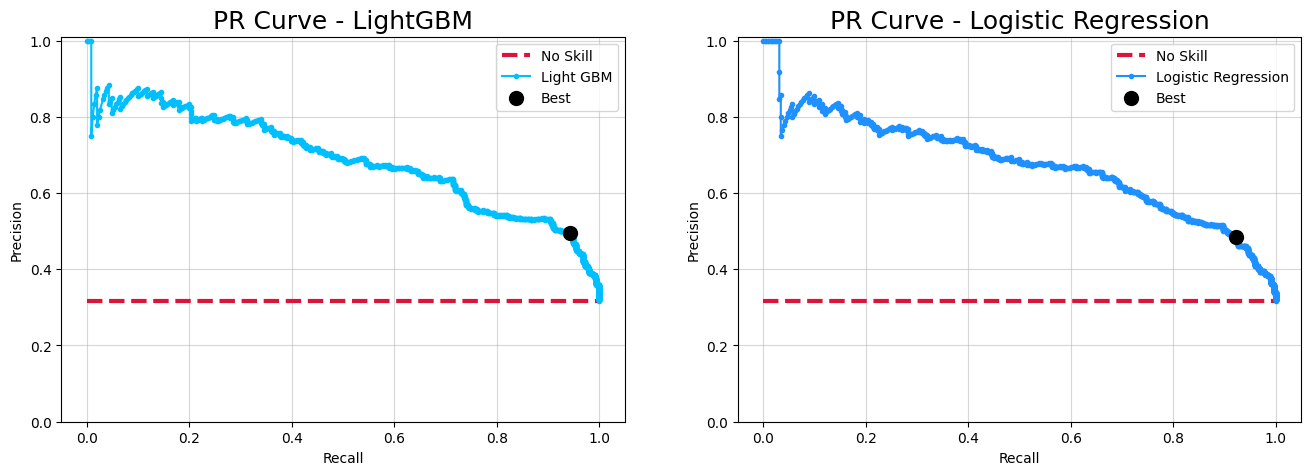

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
pr_metrics_lgbm = fr.pr_curve_plot(y_test
                                  ,probas_lgbm.Probability
                                  ,f_score_beta=2
                                  ,model_name='Light GBM'
                                  ,ax=ax1
                                  ,curve_color='deepskyblue'
                                  ,title='PR Curve - LightGBM'
                                   )

pr_metrics_lr = fr.pr_curve_plot(y_test
                                ,probas_lr.Probability
                                ,f_score_beta=2
                                ,model_name='Logistic Regression'
                                ,ax=ax2
                                ,title='PR Curve - Logistic Regression'
                                 )

plt.show()

In [22]:
pr_metrics = pd.concat([pr_metrics_lgbm, pr_metrics_lr], axis=0)
pr_metrics

,Model,Best_threshold,F2 Score,PR_AUC
0,Light GBM,0.155498,0.797975,0.687622
0,Logistic Regression,0.164038,0.782231,0.677261


Nuevamente contramos gráficos muy similares, en este caso el de precisión vs recall. Cabe destacar que es normal ver que la relación entre el crecimiento de Precision y Recall sea negativa, lo cual nos hace vernos obligados a sacrificar parte de uno si queremos mejorar el otro.

En este caso el punto negro indica el punto óptimo para maximizar la métrica F2 Score, métrica similar al F1 pero que dota de una mayor importancia relativa al recall. Si buscamos un punto que optimize el F2 se obtendrá un Recall cercano al 90%, pero sacrificando precisión hasta cerca del 50%. Aunque parezca muy bueno tener un recall tan alto, es probable que, por lo mismo que se detalló con anterioridad de los costos que puede implicar ofrecer a tanta gente el tratamiento, el threshold elegido sea superior al 15-16% como el que surge de este gráfico.

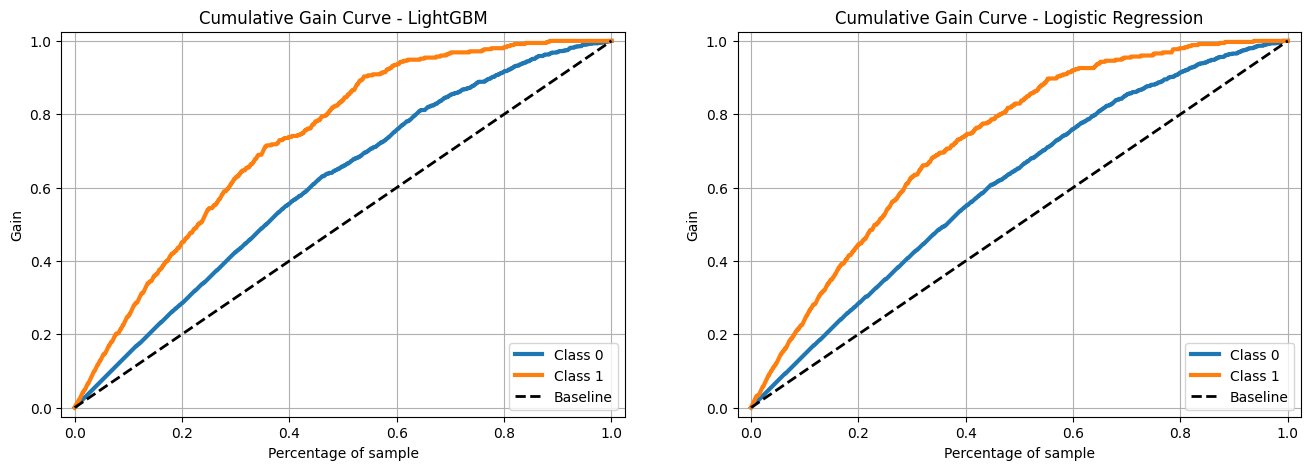

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_lgbm, ax=ax1, title='Cumulative Gain Curve - LightGBM')
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_lr, ax=ax2, title='Cumulative Gain Curve - Logistic Regression')
ax1.set_xlim([-0.025, 1.025])
ax1.set_ylim([-0.025, 1.025])
ax2.set_xlim([-0.025, 1.025])
ax2.set_ylim([-0.025, 1.025])
plt.show()

En este gráfico podemos observar como, si ordenamos las probabilidades de mayor a menor, podemos de alguna manera medir la potencia de nuestro modelo. Es decir, en ambos casos con menos del 60% de los datos se podría predecir más del 90% de los clientes que se fugaron.

Esto nos permite conocer, por ejemplo, a cuantos potenciales fugas ofrecer un tratamiento en caso de lograr obtener probabilidades precisas para cada individuo y ordenarlas de mayor a menor.


## Búsqueda del Threshold ideal

A continuación se genran dos gráficos que permiten visualizar el intercambio entre las métricas de Precision y Recall a medida que cambia el valor del threshold. Además, también se muestran el F1 y el F2 score.

Este gráfico tiene la gran ventaja de lograr representar gráficamente parte de lo que se busca al determinar el threshold: medir las combinaciones de las principales métricas analizadas por cada threshold que se elija.

In [24]:
%%time
prob_predictions_lgbm = probas_lgbm.Probability
recall_precision_lgbm = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions_lgbm]
    recall_precision_lgbm.append([threshold, recall_score(y_test, given_threshold)
                            ,precision_score(y_test, given_threshold)
                            ,fbeta_score(y_test, given_threshold, beta=2)
                            ,f1_score(y_test, given_threshold)])

prob_predictions_lr = probas_lr.Probability
recall_precision_lr = []

for threshold in np.arange(0.01, 0.99, 0.01):
    given_threshold = [1 if value>threshold else 0 for value in prob_predictions_lr]
    recall_precision_lr.append([threshold, recall_score(y_test, given_threshold)
                            ,precision_score(y_test, given_threshold)
                            ,fbeta_score(y_test, given_threshold, beta=2)
                            ,f1_score(y_test, given_threshold)])

CPU times: total: 734 ms
Wall time: 1.84 s


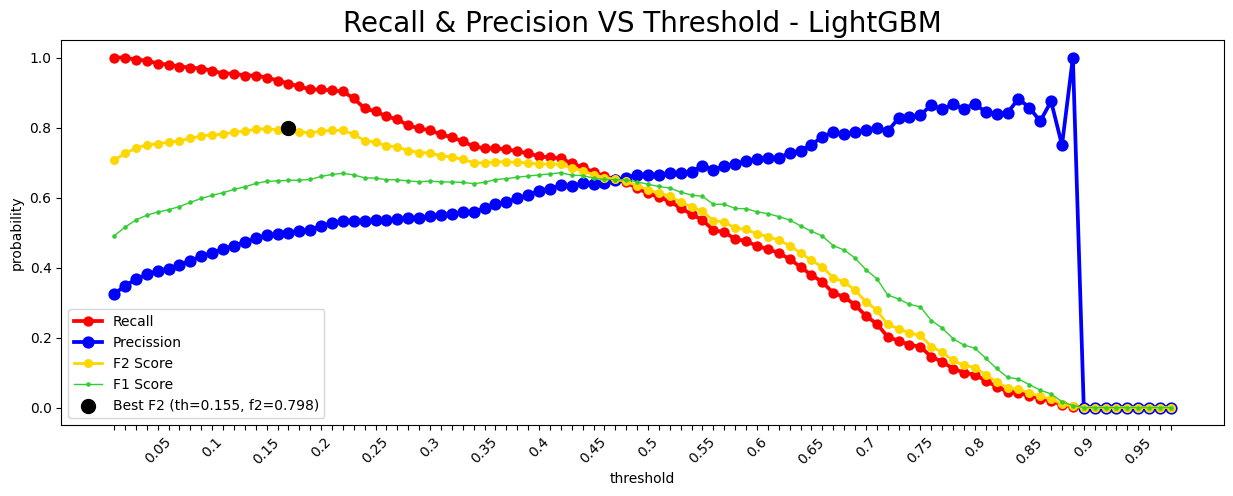

In [27]:
fr.plot_recall_precission(recall_precision_lgbm, y_test, probas_lgbm.Probability, title='Recall & Precision VS Threshold - LightGBM')

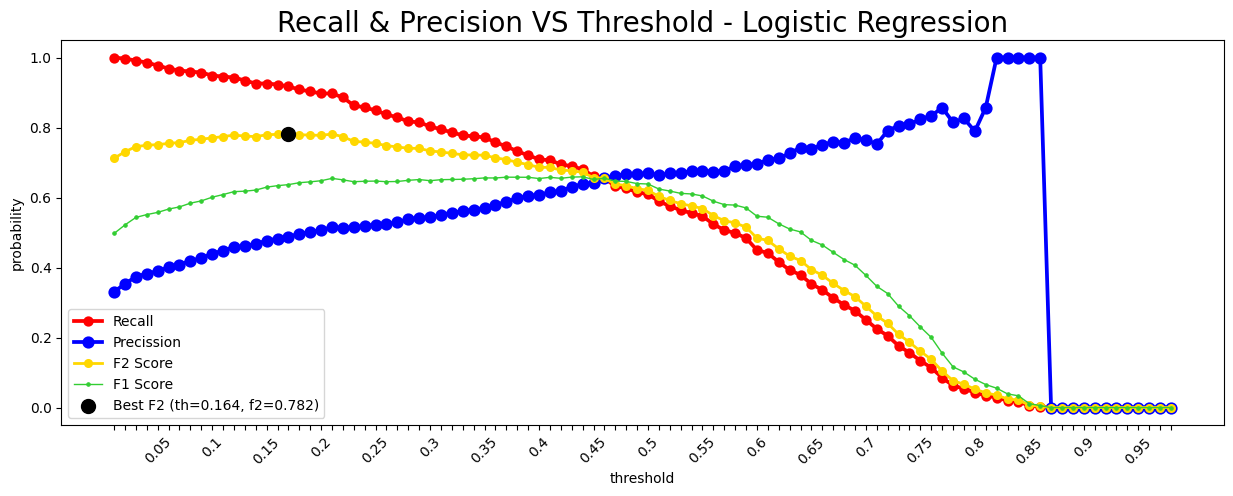

In [28]:
fr.plot_recall_precission(recall_precision_lr, y_test, probas_lr.Probability, title='Recall & Precision VS Threshold - Logistic Regression')

Podemos ver que el mejor threshold para el F2 se aleja de la intersección de las series. El F1 se acercaría más, pero el equilibrio perfecto entre ambas métricas no es necesariamente lo que mejor se condice con los objetivos del negocio, esto puede variar por supuesto.

Este gráfico permite no solo ver el threshold ideal, sino también ver cómo se posicionarían las métricas en caso de ir aumentando o disminuyendo ese threshold. Si lo que se pretende es, como en este caso, privilegiar en parte el recall sobre la precisión, seguramente el threshold a elegir ronde el 40% o menos en ambos modelos.

***
Una vez realizado el análisis gráfico, se procede a realizar una comparativa de algunos threshold para personalizar la decisión del modelo de asignar como propenso a fraude o no a los usuarios. Para esto se utilizarán los puntos de corte obtenidos y se compararán las métricas resultantes sumado a las matrices de confusión.

Es importante resaltar que en este punto se deberían tomar en cuenta las directrices de negocio, en el sentido de que dependiendo de lo que se busque con el modelo y de aplicación empresarial que se le de, se podrían privilegiar algunas métricas por sobre otras. Por ejemplo, en caso de contar con muchos recursos y estar dispuestos a utilizarlos para aumentar la retención, es posible que se busque contar con un mayor recall a costas de la precisión, con el fin de aplicar tratamientos sobre las posibles fugas de clientes. Al revés sería en caso de no contar con muchos recursos y querer solo ir a por aquellos clientes sobre los que se esté muy seguro de que pueden fugarse, en donde se privilegiaría la precisión y el accuracy.

In [104]:
lgbm_roc_th = roc_metrics.loc[roc_metrics.Model == 'Light GBM', 'Best_threshold'].values[0]
lr_roc_th = roc_metrics.loc[roc_metrics.Model == 'Logistic Regression', 'Best_threshold'].values[0]

lgbm_pr_th = pr_metrics.loc[pr_metrics.Model == 'Light GBM', 'Best_threshold'].values[0]
lr_pr_th = pr_metrics.loc[pr_metrics.Model == 'Logistic Regression', 'Best_threshold'].values[0]

lgbm_balanced_th = lr_roc_th.copy()

In [52]:
y_pred_lgbm_roc = np.where(probas_lgbm.Probability > lgbm_roc_th, 1, 0)
y_pred_lgbm_f2 = np.where(probas_lgbm.Probability > lgbm_pr_th, 1, 0) 
y_pred_lgbm_balanced = np.where(probas_lgbm.Probability > lgbm_balanced_th, 1, 0) 

y_pred_lr_roc = np.where(probas_lr.Probability > lr_roc_th, 1, 0)
y_pred_lr_f2 = np.where(probas_lr.Probability > lr_pr_th, 1, 0)

In [53]:
th_metrics = pd.DataFrame()

print(f"\033[1mLightGBM - Máximizando el F2 --> Threshold {lgbm_pr_th:.3f}:\033[0m")
th_metrics = pd.concat([th_metrics, fr.metrics_summ(y_test, y_pred_lgbm_f2, model_name=f'LightGBM - th={lgbm_pr_th:.3f}')], axis=0)
print('__________________________________________\n')

print(f"\033[1mLightGBM - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold {lgbm_roc_th:.3f}\033[0m")
th_metrics = pd.concat([th_metrics, fr.metrics_summ(y_test, y_pred_lgbm_roc, model_name=f'LightGBM - th={lgbm_roc_th:.3f}')], axis=0)
print('\n')

print(f"\033[1mLightGBM - Más balanceado, como el Linear Regression --> Threshold {lgbm_balanced_th:.3f}\033[0m")
th_metrics = pd.concat([th_metrics, fr.metrics_summ(y_test, y_pred_lgbm_balanced, model_name=f'LightGBM - {lgbm_balanced_th:.3f}')], axis=0)
print('\n')

print('\033[1m-------------------------------------------------------------------------\033[0m \n')

print(f"\033[1mLogistic Regression - Máximizando el F2 --> Threshold {lr_pr_th:.3f}:\033[0m")
th_metrics = pd.concat([th_metrics, fr.metrics_summ(y_test, y_pred_lr_f2, model_name=f'Logistic Regression - th={lr_pr_th:.3f}')], axis=0)
print('__________________________________________\n')

print(f"\033[1mLogistic Regression - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold {lr_roc_th:.3f}\033[0m")
th_metrics = pd.concat([th_metrics, fr.metrics_summ(y_test, y_pred_lr_roc, model_name=f'Logistic Regression - th={lr_roc_th:.3f}')], axis=0)

LightGBM - Máximizando el F2 --> Threshold 0.155:

Accuracy: 0.67391
Balanced Accuracy: 0.74499
F2 score: 0.79595
F1 score: 0.64706
Precision: 0.49327
Recall: 0.94017

Confusion Matrix:
[[414 339]
 [ 21 330]]
__________________________________________

LightGBM - Mejor proporción promedio TP y FP, óptimo curva ROC --> Threshold 0.420

Accuracy: 0.77808
Balanced Accuracy: 0.76051
F2 score: 0.69522
F1 score: 0.67114
Precision: 0.63452
Recall: 0.71225

Confusion Matrix:
[[609 144]
 [101 250]]


LightGBM - Más balanceado, como el Linear Regression --> Threshold 0.385

Accuracy: 0.75996
Balanced Accuracy: 0.75179
F2 score: 0.69945
F1 score: 0.65894
Precision: 0.60094
Recall: 0.72934

Confusion Matrix:
[[583 170]
 [ 95 256]]


------------------------------------------------------------------------- 

Logistic Regression - Máximizando el F2 --> Threshold 0.164:

Accuracy: 0.66395
Balanced Accuracy: 0.73236
F2 score: 0.78019
F1 score: 0.63520
Precision: 0.48498
Recall: 0.92023

Confusion Matr

In [54]:
th_metrics

,Model,Accuracy,Balanced Accuracy,F2 Score,F1 Score,Precision,Recall
0,LightGBM - th=0.155,0.673913,0.744986,0.795948,0.647059,0.493274,0.940171
0,LightGBM - th=0.420,0.778080,0.760508,0.695217,0.671141,0.634518,0.712251
0,LightGBM - 0.385,0.759964,0.751791,0.699454,0.658945,0.600939,0.729345
0,Logistic Regression - th=0.164,0.663949,0.732358,0.780193,0.635202,0.484985,0.920228
0,Logistic Regression - th=0.385,0.759964,0.751791,0.699454,0.658945,0.600939,0.729345


Una vez vistos los diferentes thresholds y las capacidades de los modelos, se plantean dos matrices de confusión con algunos de ellos (no se incluyen todas porque sería demasiado y el concepto queda claro). En base a la necesidad del negocio se priorizará una métrica u otra.

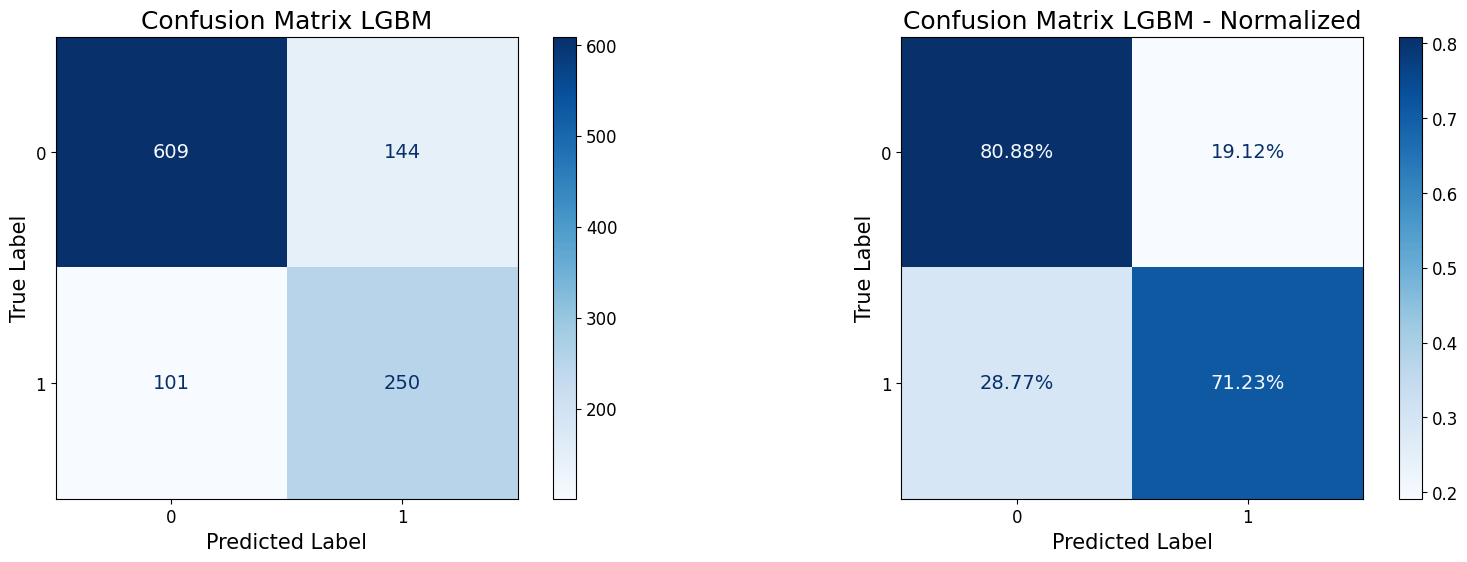

In [34]:
fr.plot_cmatrix(y_test, y_pred_lgbm_roc, title='Confusion Matrix LGBM')

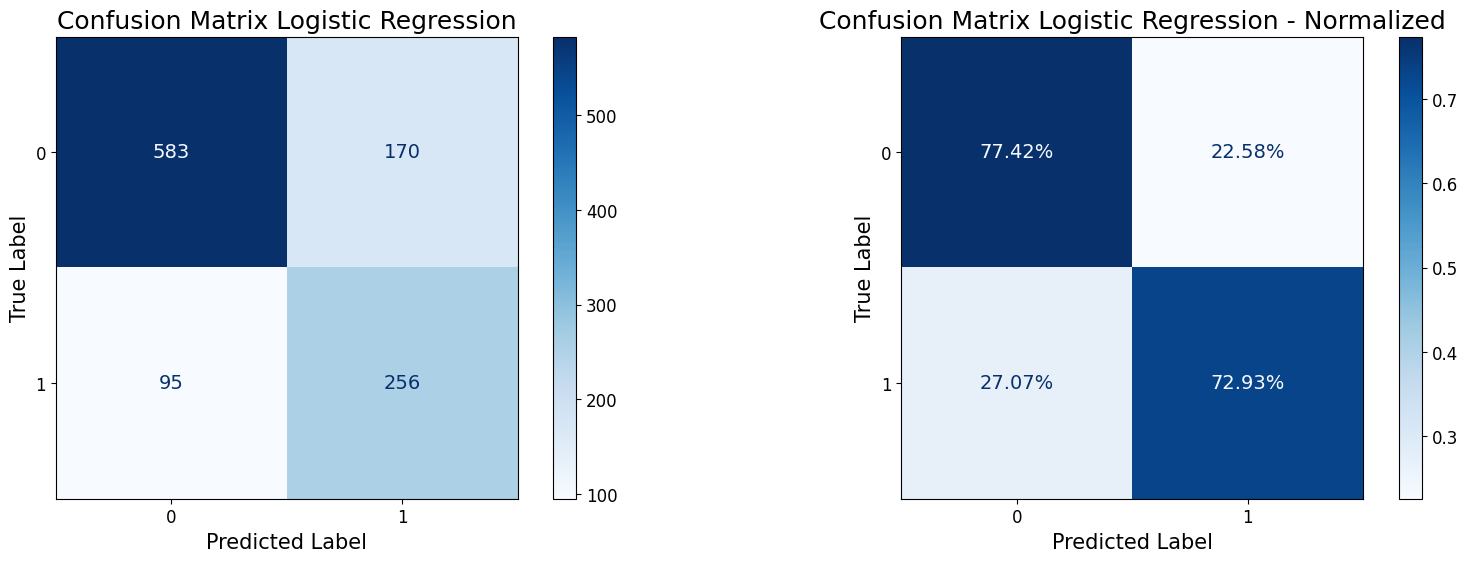

In [35]:
fr.plot_cmatrix(y_test, y_pred_lr_roc, title='Confusion Matrix Logistic Regression')

Ya con todo lo referente al modelado predictivo definido, quedando a definición según la necesidad del negocio el threshold a seleccionar, se procede a exponer la aplicación del modelado causal:

# Modelado Causal

Este apartado será veloz debido a que todas las explicaciones se han dado en el notebook anterior. Básicamente se generará el modelo X-Learner de la librería EconML, compuesto por un LGBMRegressor para el cálculo de los counterfactuals y por una LogisticRegression para el ajuste por propensity score. El modelo se entrenará con los datos del set de train y se aplicará sobre los datos del set de test para generar los CATE de cada instancia.

In [67]:
xlearner = XLearner(models=LGBMRegressor(verbose=-1, max_depth=3, learning_rate=0.04, lambda_l1=1, lambda_l2=5, random_state=SEED)
                    ,propensity_model=LogisticRegression())

In [68]:
xlearner.fit(Y=y_train.values, T=X_train_t['Tech Support'].values, X=X_train_t.drop('Tech Support', axis=1).values, inference="bootstrap")

In [69]:
cate_test = xlearner.effect(X_test_t.drop('Tech Support', axis=1).values)

In [70]:
pd.Series(cate_test).describe()

count    1104.000000
mean       -0.073101
std         0.071521
min        -0.266142
25%        -0.123346
50%        -0.069338
75%        -0.015738
max         0.134232
dtype: float64

In [71]:
pd.Series(xlearner.effect(X_train_t.drop('Tech Support', axis=1).values)).describe()

count    4413.000000
mean       -0.072020
std         0.069473
min        -0.272919
25%        -0.121061
50%        -0.066006
75%        -0.016126
max         0.117661
dtype: float64

In [72]:
xlearner.ate(X_test_t.drop('Tech Support', axis=1).values)

Vemos que el ATE es muy similar al visto en el dataset de Train, lo cual es una buena señal de que no hay overfitting.

In [73]:
xlearner.ate_interval(X_test_t.drop('Tech Support', axis=1).values)

In [74]:
xlearner.ate(X_train_t.drop('Tech Support', axis=1).values)

In [75]:
xlearner.ate_interval(X_train_t.drop('Tech Support', axis=1).values)

In [76]:
(xlearner
 .effect_interval(X_test_t.drop('Tech Support', axis=1).values, alpha=0.05)[0]
 .mean()
 
 ,xlearner
 .effect_interval(X_test_t.drop('Tech Support', axis=1).values, alpha=0.05)[1]
 .mean()
)

# Aplicación de resultados a inputs de negocio

Una vez obtenidos los resultados, se crea un nuevo dataset en donde se aglutinarán los resultados del modelado predictivo y causal, con el fin de pensar en una estrategia de negocio para tratar a los clientes propensos a la fuga.

In [77]:
df_cates = df_aux_lgbm.copy()
df_cates['CATE'] = pd.Series(cate_test).copy()
df_cates

,y_pred_proba,index,y_true,CATE
0,0.877256,515,1,-0.218639
1,0.554158,597,1,-0.085369
2,0.544986,3967,0,-0.150826
3,0.033782,1985,0,0.022189
4,0.023044,5737,0,0.010813
...,...,...,...,...
1099,0.069885,969,1,-0.017335
1100,0.681303,642,1,-0.240003
1101,0.018970,5262,0,0.023362
1102,0.735631,822,1,-0.222968


Lo que a continuación se procede a realizar es un scatterplot en donde se cruzan el CATE (resultado del modelado causal) y la probabilidad de fuga de los clientes. Además, se pintan dos líneas, una referente al posible threshold seleccionado por negocio para definir los clientes propensos a la fuga en el eje y, y otra en este caso situada en el 0 del eje x, punto divisor entre los clientes a los cuales, según el CATE, la aplicación del tratamiento les disminuiría o aumentaría la propención a fraude.

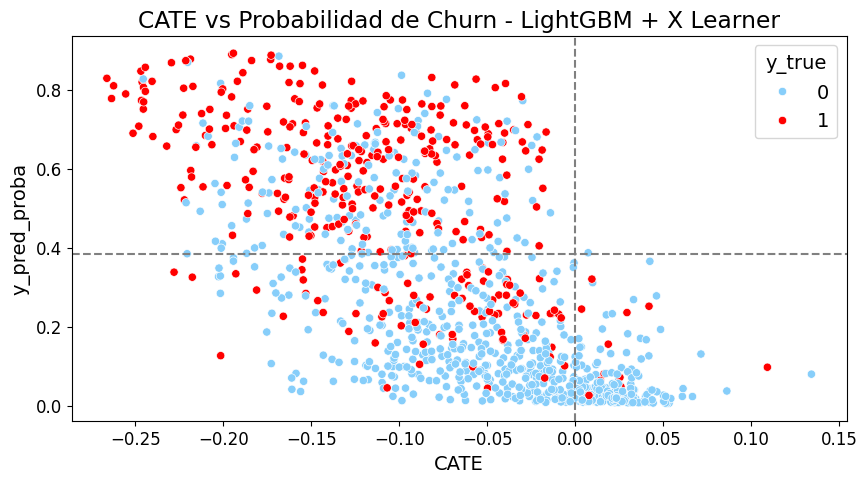

In [55]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(data=df_cates
                ,x='CATE'
                ,y='y_pred_proba'
                ,hue='y_true'
                ,palette={0:'lightskyblue', 1:'red'}
                ,ax=ax)

# línea negra a rayas intermitentes en y=0,4
ax.axhline(y=lgbm_balanced_th, color='grey', linestyle='--')
ax.axvline(x=0, color='grey', linestyle='--')

ax.set_title('CATE vs Probabilidad de Churn - LightGBM + X Learner')

plt.show()

Esto nos permite diferenciar al menos en 3 grupos a los individuos:
1. En primer lugar, el cuadrante superior izquierdo, en donde se encuentran clientes con probabilidad de fuga alta, y cuyo CATE indica que el tratamiento tendría un efecto positivo para disminuír esa probabilidad, por lo que serían los clientes idóneos para ofrecerle una promoción o directamente el tratamiento de manera gratuíta.
2. En segundo lugar, todos los clientes a la derecha de la línea del 0 en el eje x, a quienes no habría que ofrecerles el tratamiento de ninguna manera, ya que, como se ha demostrado en diferentes estudios, existen clientes a los que un contacto podría generar que desarrollen una mayor propención a la fuga.
3. Finalmente, en el cuadrante inferior izquierdo, los clientes a los que no es necesario ofrecerles el tratamiento, ya que, aunque pudiese disminuír su propención a la fuga, no cuentan con una probabilidad lo suficientemente alta como para invertir en ellos.

Una vez determinados los grupos, se agrega el Customer Life Time Value al dataframe, debido a que es una métrica muy usada en empresas como Mapfre para tener en cuenta a la hora de priorización de clientes a tratar.

In [83]:
df_cates['CLTV'] = X_test.CLTV.copy().reset_index(drop=True)
df_cates

,y_pred_proba,index,y_true,CATE,CLTV
0,0.877256,515,1,-0.218639,5536
1,0.554158,597,1,-0.085369,3425
2,0.544986,3967,0,-0.150826,2013
3,0.033782,1985,0,0.022189,5769
4,0.023044,5737,0,0.010813,4437
...,...,...,...,...,...
1099,0.069885,969,1,-0.017335,5516
1100,0.681303,642,1,-0.240003,2548
1101,0.018970,5262,0,0.023362,4298
1102,0.735631,822,1,-0.222968,2293


Se genera un dataframe de los clientes a los que se les aplicaría el tratamiento:

In [84]:
aplicar_treatment = df_cates[(df_cates.y_pred_proba > lgbm_balanced_th) & (df_cates.CATE < 0)]
display(aplicar_treatment.head(), aplicar_treatment.shape)

,y_pred_proba,index,y_true,CATE,CLTV
0,0.877256,515,1,-0.218639,5536
1,0.554158,597,1,-0.085369,3425
2,0.544986,3967,0,-0.150826,2013
6,0.522660,1544,1,-0.165456,3853
10,0.488396,2021,0,-0.059976,4400


In [85]:
aplicar_treatment.y_true.value_counts(normalize=True)

y_true
1    0.602353
0    0.397647
Name: proportion, dtype: float64

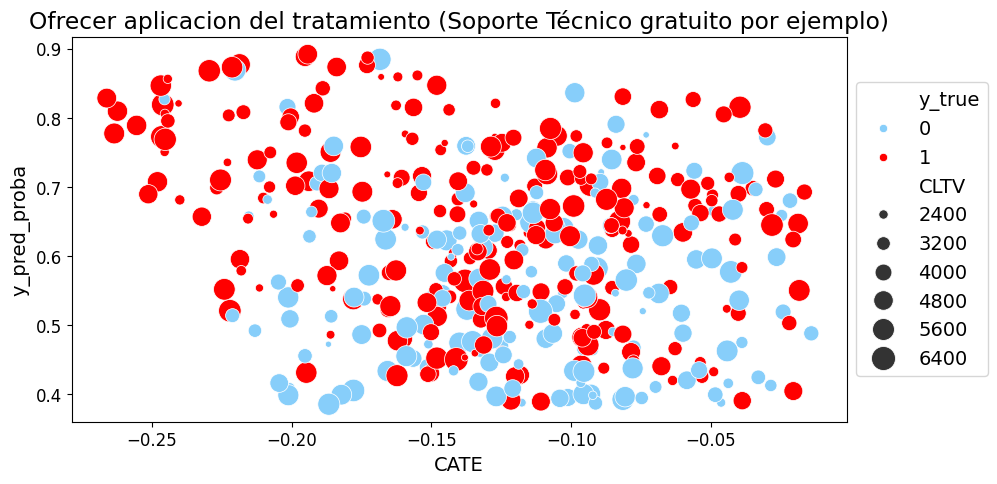

In [103]:
fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(data=aplicar_treatment
                ,x='CATE'
                ,y='y_pred_proba'
                ,hue='y_true'
                ,palette={0:'lightskyblue', 1:'red'}
                ,ax=ax
                ,size='CLTV'
                ,sizes=(20, 300))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Ofrecer aplicacion del tratamiento (Soporte Técnico gratuito por ejemplo)')

plt.show()

Finalmente, con este gráfico se muestra el cuadrante de los clientes a los que aplicar el tratamiento, en donde en este caso las burbujas de mayor tamaño se corresponden con el CLTV más alto, es decir, a quienes se debería priorizar para ofrecerles el tratamiento.

In [99]:
df_test_to_treat = df_test_raw.reset_index(drop=False).copy()
df_test_to_treat = df_test_to_treat[df_test_to_treat['index'].isin(aplicar_treatment['index'].values)]

In [100]:
display(df_test_to_treat.head(), df_test_to_treat.shape)

,index,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,Churn Value
0,515,9497-QCMMS,1,United States,California,Escondido,92026,"33.21846, -117.116916",33.218460,-117.116916,Male,Yes,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.55,93.55,Yes,81,5536,Competitor made better offer,1
1,597,0320-JDNQG,1,United States,California,Oxnard,93035,"34.18454, -119.224666",34.184540,-119.224666,Male,No,Yes,No,23,Yes,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,99.85,2331.30,Yes,83,3425,Don't know,1
2,3967,9743-DQKQW,1,United States,California,Escalon,95320,"37.818543, -121.006907",37.818543,-121.006907,Male,No,No,No,3,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,25.10,79.80,No,58,2013,None,0
6,1544,3398-ZOUAA,1,United States,California,Redwood City,94063,"37.499411, -122.196318",37.499411,-122.196318,Male,Yes,Yes,No,21,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.10,1474.75,Yes,67,3853,Attitude of support person,1
10,2021,8544-GOQSH,1,United States,California,Pacoima,91331,"34.255442, -118.421314",34.255442,-118.421314,Female,No,No,No,14,Yes,No,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),80.05,1112.30,No,53,4400,None,0


Finalmente, ya con el dataset de personas a quienes aplicaría el tratamiento armado, se procede a exportar los datos y modelos resultantes.

# Exportando modelos y dataframes procesados

In [101]:
joblib.dump(lgbm, '../models/lgbm_model.joblib')
joblib.dump(lr, '../models/logistic_regression_model.joblib')
joblib.dump(xlearner, '../models/Xlearner_model.joblib')

['../models/Xlearner_model.joblib']

In [102]:
df_train.to_parquet('../data/ibm_telco_churn/processed/df_train_processed.parquet')
df_test.to_parquet('../data/ibm_telco_churn/processed/df_test_processed.parquet')
df_cates.to_parquet('../data/ibm_telco_churn/processed/df_cates.parquet')
aplicar_treatment.to_parquet('../data/ibm_telco_churn/processed/df_aplicar_treatment.parquet')